In [1]:
import tensorflow as tf
import tensorflow.keras

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore', category = DeprecationWarning)
import nltk
from nltk import word_tokenize
from datetime import datetime
import scipy.stats.distributions as dist

from statsmodels.stats.proportion import proportions_ztest


from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime

import string
import re


In [3]:
pd.set_option('display.max_columns', None)

file = pd.read_csv(r'C:\Users\xuanx\Desktop\Steam_Reviews\steam_reviews.csv')

In [4]:
file['language'].value_counts()[:5]

language
english      9635437
schinese     3764967
russian      2348900
brazilian     837524
spanish       813320
Name: count, dtype: int64

In [5]:
#pick out english reviews only
df = file[file['language'] == 'english']

In [6]:
#Checking review column for null values and removing them.
print(df.review.isnull().sum())
df1 = df[df.review.isnull()== False]

16754


In [7]:
df1['recommended'].value_counts()

recommended
True     8568123
False    1050560
Name: count, dtype: int64

In [8]:
#Hypothesis testing: early access population mean versus release reviews means
df1.groupby('written_during_early_access')['recommended'].value_counts()

written_during_early_access  recommended
False                        True           7740537
                             False           919809
True                         True            827586
                             False           130751
Name: count, dtype: int64

In [9]:
prop = df1.groupby('written_during_early_access')['recommended'].value_counts(normalize = True)
prop

written_during_early_access  recommended
False                        True           0.893791
                             False          0.106209
True                         True           0.863565
                             False          0.136435
Name: proportion, dtype: float64

In [10]:
n = df1.groupby('written_during_early_access')['recommended'].count()
n

written_during_early_access
False    8660346
True      958337
Name: recommended, dtype: int64

In [11]:
prop_early = prop[(True, False)]
prop_not_early = prop[(False, False)]
print(prop_early, prop_not_early)

0.1364353040736192 0.10620926692767241


In [12]:
n_early = n[True]
n_not_early = n[False]
print(n_early, n_not_early)

958337 8660346


In [13]:
p_hat = (n_early * prop_early + n_not_early * prop_not_early) / (n_early + n_not_early)
std_error = np.sqrt(p_hat * (1-p_hat) / n_early + p_hat * (1-p_hat) / n_not_early)
z_score = (prop_early - prop_not_early) / std_error
print(z_score)

90.01450357342455


In [14]:
n_not_recommended = np.array([2644, 2597])
n_row = np.array([14424 + 2644, 6717 + 2597])
from statsmodels.stats.proportion import proportions_ztest
z_score, p_value = proportions_ztest(count = n_not_recommended, nobs = n_row, alternative = 'two-sided')
z_score, p_value

#Reject null hypothesis.
#There is a difference in proportion between not recommended reviews in early access and not recommended reviews outside
# of early access at a 1% level of significance. 

(-24.108885753632578, 2.0170192587670853e-128)

In [15]:
#received for free population reviews versus paid population reviews

df1.groupby('received_for_free')['recommended'].value_counts()

received_for_free  recommended
False              True           8319816
                   False          1019635
True               True            248307
                   False            30925
Name: count, dtype: int64

In [16]:
#received for free population = to paid population reviews?
rec_free_key = np.array([248307, 30925])
n_row = np.array([248307+30925, 8319820+1019635])

z_score, p_value = proportions_ztest(count = n_not_recommended, nobs = n_row, alternative = 'larger')
z_score, p_value

(205.07187963516282, 0.0)

In [17]:
df_clean = df1
df_20_20_samp = df_clean.groupby(['recommended'])
df_20_20_samp.size()
df_20_20 = df_20_20_samp.apply(lambda x: x.sample(3000, replace = False).reset_index(drop=True))
df_20_20['recommended'].value_counts()
#df_20_20_samp = df_clean.sample(15000, replace = False, random_state = 42)
#df_20_20_samp['recommended'].value_counts()

recommended
False    3000
True     3000
Name: count, dtype: int64

In [18]:
df_20_20['recommended'].value_counts()

recommended
False    3000
True     3000
Name: count, dtype: int64

In [19]:
df_20_20 = df_20_20.droplevel(['recommended'])

In [20]:
df_20_20.review = df_20_20.review.astype(str)

In [21]:
#Convert text to lowercase and removing punctuation 

def remove_punct(txt):
    text_input = "".join([char for char in txt if char not in string.punctuation])
    return text_input

df_20_20['token_review'] = df_20_20['review'].apply(lambda x: remove_punct(x.lower()))

In [22]:
#remove numbers

def remove_digits(txt):
    return re.sub(r' \d+', '', str(txt))

df_20_20['token_review1'] = df_20_20['token_review'].apply(lambda x: remove_digits(x))

In [23]:
#remove non alphabet characters

def remove_chars(txt):
    return re.sub("[^a-zA-Z]+", ' ', txt)

df_20_20['token_review2'] = df_20_20['token_review1'].apply(lambda x: remove_chars(x))

In [24]:
#Convert reviews into tokens

def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens

df_20_20['token_review3'] = df_20_20['token_review2'].apply(lambda x: tokenize(x))

In [25]:
#remove stopwords

stopword = nltk.corpus.stopwords.words('english')

def rem_stopwords(txt):
    text = [word for word in txt if word not in stopword]
    return text

df_20_20['token_review4'] = df_20_20['token_review3'].apply(lambda x: rem_stopwords(x))
    

In [26]:
#convert words to base form 
wn = nltk.WordNetLemmatizer()

def lemmatizer(txt):
    text = [wn.lemmatize(word) for word in txt]
    return text

df_20_20['token_review5']=df_20_20['token_review4'].apply(lambda x: lemmatizer(x))

In [27]:
df_20_20['reviews_fin'] = df_20_20['token_review5'].apply(lambda x:' '.join(x))
#df_20_20['rec_var'] = df_20_20['recommended'].apply(lambda x: 0 if x==1 else 1)

In [28]:
print(df_20_20.reviews_fin.isnull().sum())

0


In [29]:
pos_reviews = df_20_20[df_20_20['recommended']== 1] #majority: variable positive reviews
neg_reviews = df_20_20[df_20_20['recommended']== 0] #minority: variable negative reviews

In [30]:
print(pos_reviews['review'].count(),
    neg_reviews['review'].count())

3000 3000


In [31]:
from nltk.probability import FreqDist

pos_rev_words = pos_reviews['token_review5']
pos_words = []
for reviews in pos_rev_words: 
    pos_words += reviews
    
freqdist_pos = FreqDist(pos_words)
freqdist_pos

FreqDist({'game': 3133, 'good': 651, 'fun': 614, 'like': 562, '': 482, 'get': 464, 'play': 464, 'great': 442, 'one': 394, 'time': 383, ...})

In [32]:
neg_rev_words = neg_reviews['token_review5']
neg_words = []
for reviews in neg_rev_words: 
    neg_words += reviews
    
freqdist_neg = FreqDist(neg_words)
freqdist_neg

FreqDist({'game': 5908, 'like': 1150, 'get': 1015, 'time': 913, 'play': 815, 'even': 776, 'dont': 763, 'one': 672, 'good': 624, 'really': 610, ...})

<function matplotlib.pyplot.show(close=None, block=None)>

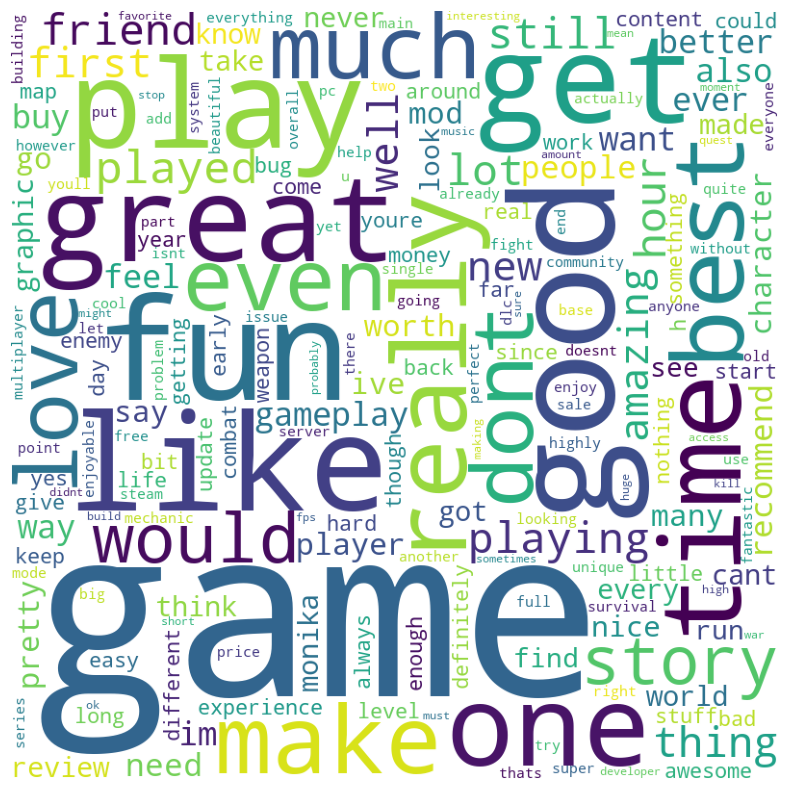

In [33]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'white',
                     stopwords = stopword,
                     min_font_size = 10).generate_from_frequencies(freqdist_pos)

plt.figure(figsize = (10,10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('postive.png')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

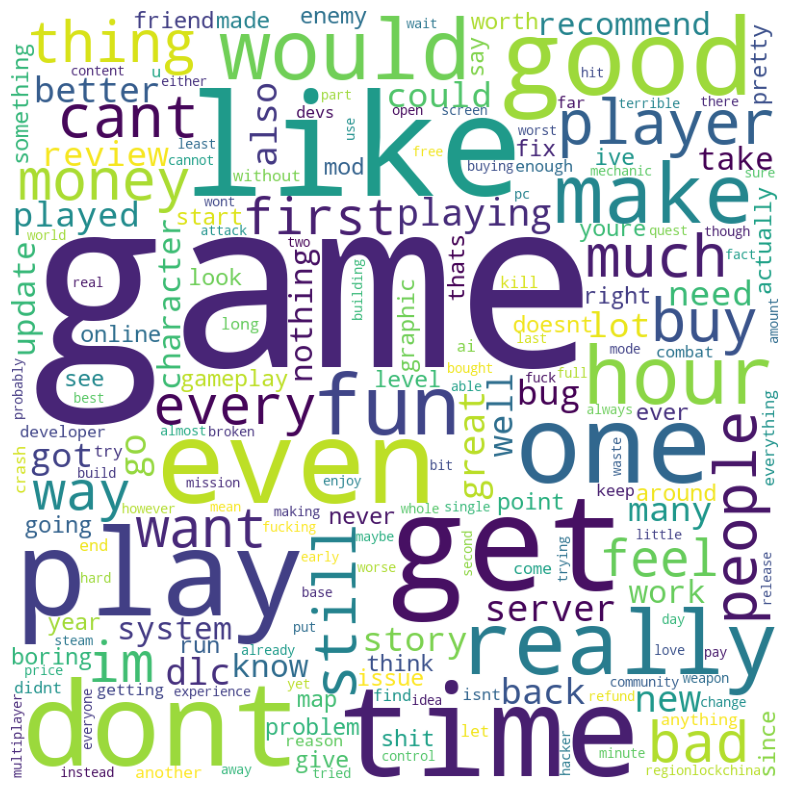

In [34]:
wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'white',
                     stopwords = stopword,
                     min_font_size = 10).generate_from_frequencies(freqdist_neg)

plt.figure(figsize = (10,10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('negative.png')
plt.show


In [35]:
(pd.Series(nltk.ngrams(pos_words, 2)).value_counts())[:10]

(good, game)        160
(great, game)       154
(monika, monika)    105
(best, game)         97
(love, game)         85
(one, best)          77
(fun, game)          74
(game, ever)         70
(game, good)         68
(ever, played)       63
Name: count, dtype: int64

In [36]:
(pd.Series(nltk.ngrams(pos_words, 3)).value_counts())[:10]

(monika, monika, monika)                103
(best, game, ever)                       35
(one, best, game)                        33
(ive, ever, played)                      29
(monikajust, monikajust, monikajust)     28
(game, ever, played)                     27
(game, ive, ever)                        22
(fun, play, friend)                      20
(, great, game)                          16
(good, game, )                           16
Name: count, dtype: int64

In [37]:
(pd.Series(nltk.ngrams(neg_words, 2)).value_counts())[:10]

(regionlockchina, regionlockchina)    159
(feel, like)                          155
(play, game)                          136
(dlc, dlc)                            121
(recommend, game)                     106
(buy, game)                           104
(great, game)                          88
(dont, buy)                            86
(good, game)                           83
(game, like)                           74
Name: count, dtype: int64

In [38]:
(pd.Series(nltk.ngrams(neg_words, 3)).value_counts())[:10]

(regionlockchina, regionlockchina, regionlockchina)    158
(dlc, dlc, dlc)                                        118
(buy, buy, buy)                                         40
(dont, buy, game)                                       24
(cant, recommend, game)                                 22
(early, access, game)                                   21
(game, feel, like)                                      18
(game, dont, buy)                                       17
(cannot, recommend, game)                               17
(dont, get, wrong)                                      16
Name: count, dtype: int64

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [125]:
train = df_20_20.reset_index().groupby(['recommended']).apply(lambda x: x.sample(frac = 0.8, random_state = 42)
                                                             ).reset_index(drop = True).set_index('index')

test = df_20_20.drop(train.index)

train['recommended'].value_counts()

recommended
False    2400
True     2400
Name: count, dtype: int64

In [41]:
X_train = train["reviews_fin"]
y_train = train['recommended']
X_test = test['reviews_fin']
y_test = test['recommended'] 

In [44]:
X_train_vec = vectorizer.transform(X_train)
X_train_arr = X_train_vec.toarray()
print(X_train_arr.shape)

(4800, 9368)


In [45]:
X_test_vec = vectorizer.transform(X_test)
X_test_arr = X_test_vec.toarray()
print(X_test_arr.shape)

(1200, 9368)


In [46]:
n_words = X_train_arr.shape[1]

In [47]:
#nn model
model = Sequential()
model.add(Dense(12, input_shape = (n_words,), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(8, activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(1, activation ='sigmoid'))

tensorBoardCallback = TensorBoard(log_dir = './logs', write_graph = True)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [48]:
start_time = datetime.datetime.now()

history = model.fit(X_train_arr, y_train, epochs = 10, verbose = 2)



Epoch 1/10
150/150 - 81s - loss: 0.6213 - accuracy: 0.6819 - 81s/epoch - 542ms/step
Epoch 2/10
150/150 - 1s - loss: 0.4244 - accuracy: 0.8650 - 911ms/epoch - 6ms/step
Epoch 3/10
150/150 - 1s - loss: 0.2613 - accuracy: 0.9112 - 902ms/epoch - 6ms/step
Epoch 4/10
150/150 - 1s - loss: 0.1754 - accuracy: 0.9385 - 909ms/epoch - 6ms/step
Epoch 5/10
150/150 - 1s - loss: 0.1325 - accuracy: 0.9527 - 871ms/epoch - 6ms/step
Epoch 6/10
150/150 - 1s - loss: 0.1065 - accuracy: 0.9594 - 1s/epoch - 7ms/step
Epoch 7/10
150/150 - 1s - loss: 0.0900 - accuracy: 0.9652 - 933ms/epoch - 6ms/step
Epoch 8/10
150/150 - 1s - loss: 0.0801 - accuracy: 0.9677 - 944ms/epoch - 6ms/step
Epoch 9/10
150/150 - 1s - loss: 0.0737 - accuracy: 0.9681 - 928ms/epoch - 6ms/step
Epoch 10/10
150/150 - 1s - loss: 0.0703 - accuracy: 0.9696 - 897ms/epoch - 6ms/step


In [49]:
loss, acc = model.evaluate(X_test_arr, y_test, verbose = 0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 81.083333


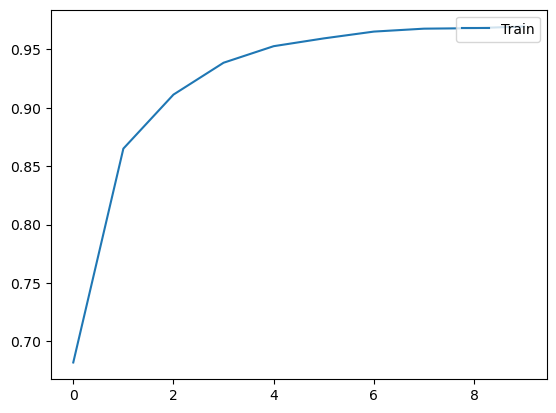

In [50]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.legend(["Train", "test"], loc = 'upper right')
plt.show()

In [51]:
import xgboost

In [120]:
#Create the pipeline

pipe = Pipeline(steps = [("vects", TfidfVectorizer()), ("classifier", RandomForestClassifier())])

#Create a dictionary with the hyperparameters
search_space = [{"vects": [TfidfVectorizer()],
                "vects__ngram_range": [(1,1), (2,2), (3,3)],
                'vects__use_idf': [True, False]},
                {"vects": [CountVectorizer()],
                "vects__ngram_range": [(1,1), (2,2), (3,3)]},
                {"classifier": [RandomForestClassifier()],
                'classifier__max_depth': [10, 20, 50, 100],
                'classifier__n_estimators': [200, 400, 600, 800],
                'classifier__max_features': ['auto','sqrt'],
                'classifier__max_depth': [20,30,60,None] },
                {"classifier": [MultinomialNB()]}
               ]


In [130]:
#create gridsearchcv object (cv=kfold) **check kfold
scoring={'AUC': 'roc_auc'}
grid = GridSearchCV(estimator = pipe, param_grid = search_space, cv = cv, scoring = "roc_auc",
                    return_train_score = True, verbose = 1, n_jobs = -1, refit = True)
best_model = grid.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


In [131]:
print(best_model.best_score_, best_model.best_estimator_, best_model.best_params_)

nan Pipeline(steps=[('vects', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())]) {'vects': TfidfVectorizer(), 'vects__ngram_range': (1, 1), 'vects__use_idf': True}


In [132]:
#building a df from cv data
cv_scores = pd.DataFrame(best_model.cv_results_).sort_values(by = 'rank_test_score')
print(cv_scores)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       11.734510      0.671957         0.172693        0.040555   
23      16.807313      1.481426         0.276199        0.024555   
24      22.643337      0.912543         0.351296        0.047050   
25       0.222706      0.019361         0.000000        0.000000   
26       0.219369      0.014035         0.000000        0.000000   
27       0.219867      0.019254         0.000000        0.000000   
28       0.225490      0.015757         0.000000        0.000000   
29      11.593924      0.934583         0.140854        0.014262   
30      23.276644      1.990640         0.238310        0.019697   
31      34.464193      2.436270         0.328931        0.022616   
32      45.210481      3.818363         0.441780        0.028539   
33       0.220003      0.014174         0.000000        0.000000   
34       0.216188      0.017307         0.000000        0.000000   
35       0.217058      0.018504         0.000000

In [124]:
y_pred = best_model.predict_proba(X_test)[:,1]
print(best_model.score(X_test, y_test))
print(roc_auc_score(y_test, y_pred))

0.8666541666666667
0.8666541666666667


In [133]:
clf = RandomForestClassifier()
vectorizer = TfidfVectorizer(ngram_range = (1,1), use_idf = True)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
clf_model = clf.fit(X_train_vect, y_train)
y_test_proba = clf_model.predict_proba(X_test_vect)[:,1]
print(roc_auc_score(y_test, y_test_proba))

0.8653152777777778


In [52]:
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_features.shape, test_vectors.shape)

(4800, 14535) (1200, 14535)


In [53]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from time import time
from pprint import pprint
import logging
from sklearn.metrics import recall_score, roc_auc_score, make_scorer, roc_curve

Performing Model Optimizations

Estimator: Naive Bayes
Best params are : {'vect__ngram_range': (1, 1)}
Best training AUC score: nan
Test set AUC score for best params: 0.867 


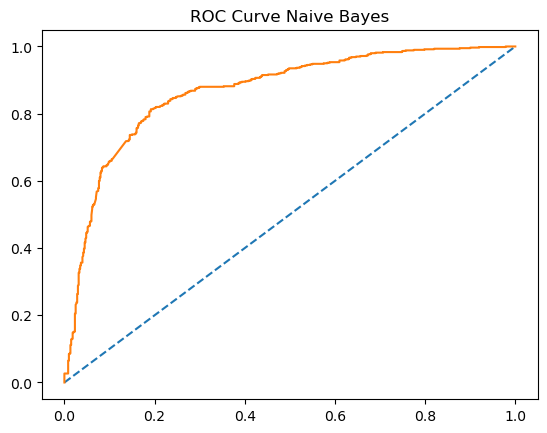


Estimator: Random Forest
Best params are : {'clf__max_depth': 10, 'clf__n_estimators': 200, 'vect__ngram_range': (1, 1)}
Best training AUC score: nan
Test set AUC score for best params: 0.784 


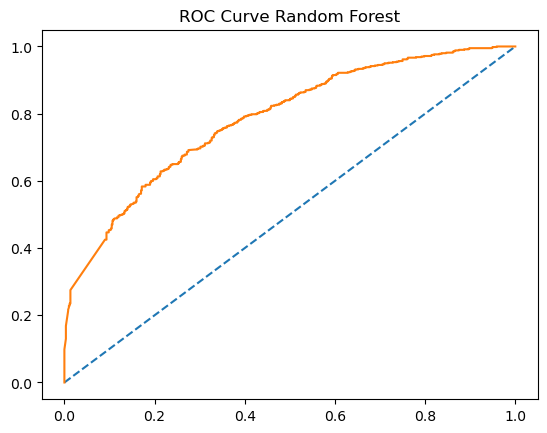


Classifier with best test set AUC: Naive Bayes


In [112]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

cv = KFold(n_splits=5)


pipe_multi = Pipeline([('vect', CountVectorizer()),
                      ('clf', MultinomialNB())])

pipe_rf = Pipeline([('vect', CountVectorizer()),
                      ('clf', RandomForestClassifier(random_state = 42))])


grid_params_multi = {'vect__ngram_range': [(1,1), (2,2), (3,3)]
                     }

grid_params_rf = {'vect__ngram_range': [(1,1), (2,2), (3,3)],
                  'clf__max_depth': [10, 20, 50, 100],
                  'clf__n_estimators': [200, 400, 600, 800]
                     }

multiNB = GridSearchCV(estimator = pipe_multi,
                      param_grid = grid_params_multi,
                      scoring = 'roc_auc',
                      cv = cv, 
                       n_jobs = -1)

rf = GridSearchCV(estimator = pipe_rf,
                  param_grid = grid_params_rf,
                  scoring = 'roc_auc',
                  cv = cv, 
                  n_jobs = -1)

grids = [multiNB, rf] #rf

grid_dict = {0: 'Naive Bayes',
            1: 'Random Forest'}

print('Performing Model Optimizations')
best_auc = 0.0
best_clf = 0
best_gs = ''

for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(X_train, y_train)
    print('Best params are : %s' % gs.best_params_)
    # Best training data recall score
    print('Best training AUC score: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred_proba = gs.predict_proba(X_test)[:,1]
    # Test data accuracy of model with best params
    print('Test set AUC score for best params: %.3f ' % roc_auc_score(y_test, y_pred_proba))
    #Plot ROC curve for each estimator
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test,y_pred_proba)
    plt.plot([0,1],[0,1], linestyle ='--')
    plt.plot(fpr, tpr, label = 'auc=%.3f' % auc)
    plt.title(label = 'ROC Curve %s' % grid_dict[idx])
    name = grid_dict[idx]
    plt.savefig(name + ".png")
    plt.show()
    # Track best (highest test auc) model
    if roc_auc_score(y_test, y_pred_proba) > best_auc:
        best_auc = roc_auc_score(y_test, y_pred_proba)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set AUC: %s' % grid_dict[best_clf])




In [129]:
cv1_scores = pd.DataFrame(rf.cv_results_).sort_values(by = 'rank_test_score')
print(cv1_scores)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.743486      0.042614         0.127339        0.039699   
26       4.756924      0.531599         0.134897        0.021381   
27      18.011870      0.957358         0.237448        0.036167   
28      17.321740      1.820487         0.232003        0.018426   
29       8.910597      1.028169         0.221826        0.026876   
30      26.663732      1.401628         0.310362        0.025215   
31      25.443380      2.776274         0.294783        0.017590   
32      12.732300      1.312158         0.278860        0.012268   
33      35.603317      1.946665         0.398452        0.041500   
34      33.958155      3.646730         0.388119        0.030580   
25       8.918132      0.909348         0.141970        0.026859   
35      16.908521      1.627350         0.350174        0.016086   
37      17.378051      2.823778         0.181778        0.016731   
38       7.921764      0.922783         0.172653

In [113]:
print(rf.best_params_)

{'clf__max_depth': 10, 'clf__n_estimators': 200, 'vect__ngram_range': (1, 1)}


In [119]:
print(rf.best_score_)

nan


In [56]:
vectorizer = TfidfVectorizer(ngram_range = (1,1))
X_train_vec = vectorizer.fit_transform(X_train)
X_train_vec_df = pd.DataFrame(X_train_vec.toarray())
X_test_vec = vectorizer.transform(X_test)
X_test_vec_df = pd.DataFrame(X_test_vec.toarray())


In [57]:
words = vectorizer.get_feature_names_out()

In [58]:
X_train_vec_df.columns = words
X_test_vec_df.columns = words

In [59]:
print(type(words))

<class 'numpy.ndarray'>


In [81]:
clf = MultinomialNB()
clf_fit = clf.fit(X_train_vec_df, y_train)


In [61]:
import shap

In [62]:
from scipy import interpolate
from sklearn import metrics

In [89]:
def f(X):
    return clf_fit.predict([X[:,i] for i in frange(X.shape[1])]).flatten()

In [90]:
explainer = shap.KernelExplainer(f, X.iloc[:50,:]), feature_names = words)
shap_values = explainer.shap_values(X.iloc[299,:], nsamples = 500)
shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])

SyntaxError: cannot assign to function call (1009073073.py, line 1)

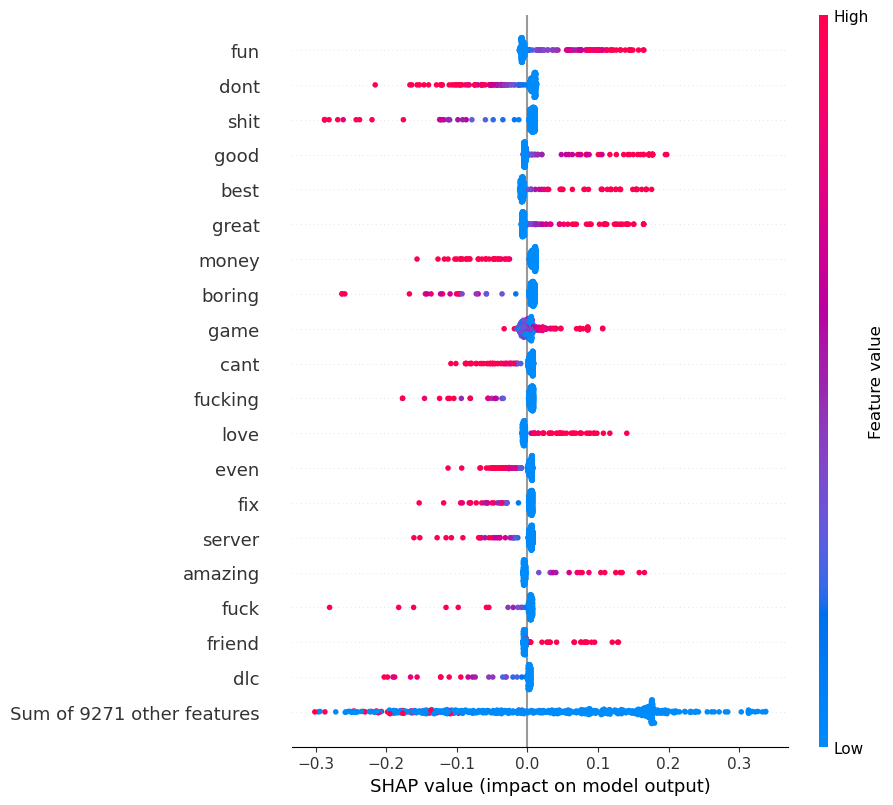

In [64]:
import copy

shap.initjs()
shap_values1 = copy.deepcopy(shap_values)
shap_values1.values = shap_values1.values[:,:,1]
shap_values1.base_values = shap_values1.base_values[:,1]

shap.plots.beeswarm(shap_values1, max_display = 20, show= False)
plt.savefig('beeswarm.png', bbox_inches="tight")

In [65]:
shap.initjs()

ind = 48
print(X_test.iloc[ind], y_test.iloc[ind])

fun gameplay corrupted save end playthrough frequently False


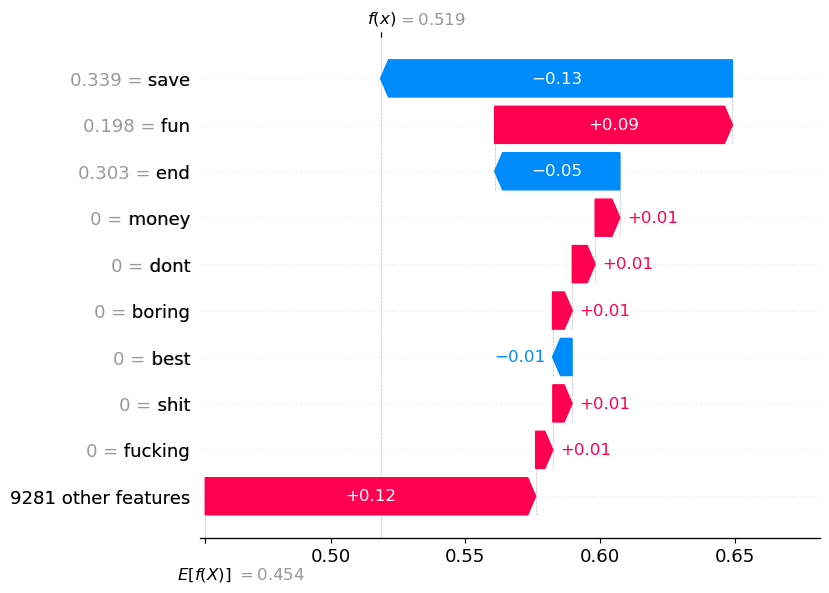

<Figure size 640x480 with 0 Axes>

In [66]:
shap.plots.waterfall(shap_values[ind,:,1], show = True)
plt.savefig('waterfall.png', bbox_inches="tight")


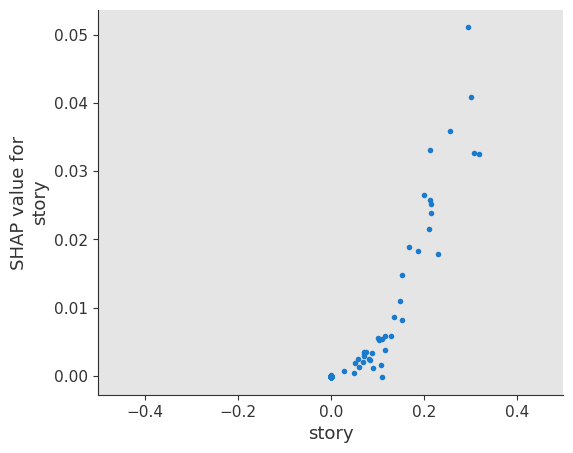

<Figure size 640x480 with 0 Axes>

In [67]:
shap.plots.scatter(shap_values[:,words.tolist().index('story'),1], show = True)

plt.savefig('scatter.png', bbox_inches="tight")

In [68]:
y_test.value_counts()

recommended
False    300
True     300
Name: count, dtype: int64

In [69]:
feature_scores = pd.Series(clf_fit.feature_importances_,
                          index = words).sort_values(ascending=False)
feature_scores[:10]


good      0.022719
fun       0.019283
game      0.018163
best      0.015411
shit      0.015210
dont      0.014744
money     0.014623
bad       0.013884
great     0.013240
boring    0.010922
dtype: float64

Best Threshold = 0.489754, F-Score = 0.785


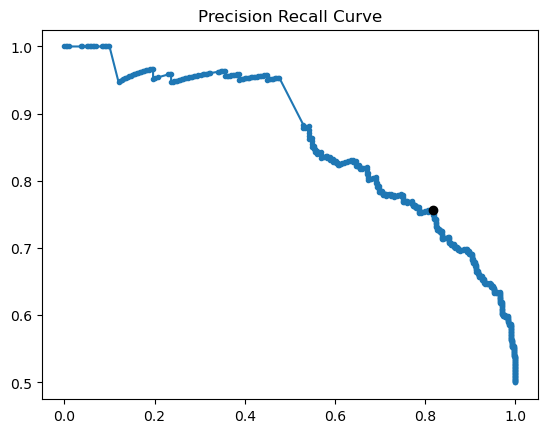

In [70]:
from sklearn.metrics import precision_recall_curve

y_pred_proba = clf_fit.predict_proba(X_test_vec_df)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold = %f, F-Score = %.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, label = 'auc=%.3f' % auc, marker = '.')
plt.plot(recall[ix], precision[ix], marker = 'o', color = 'black', label = 'Best')
plt.title(label = 'Precision Recall Curve')
plt.savefig('prec_recall.png', bbox_inches="tight")
plt.show()
optimal_thresh = thresholds[ix]
optimal_prec = precision[ix]

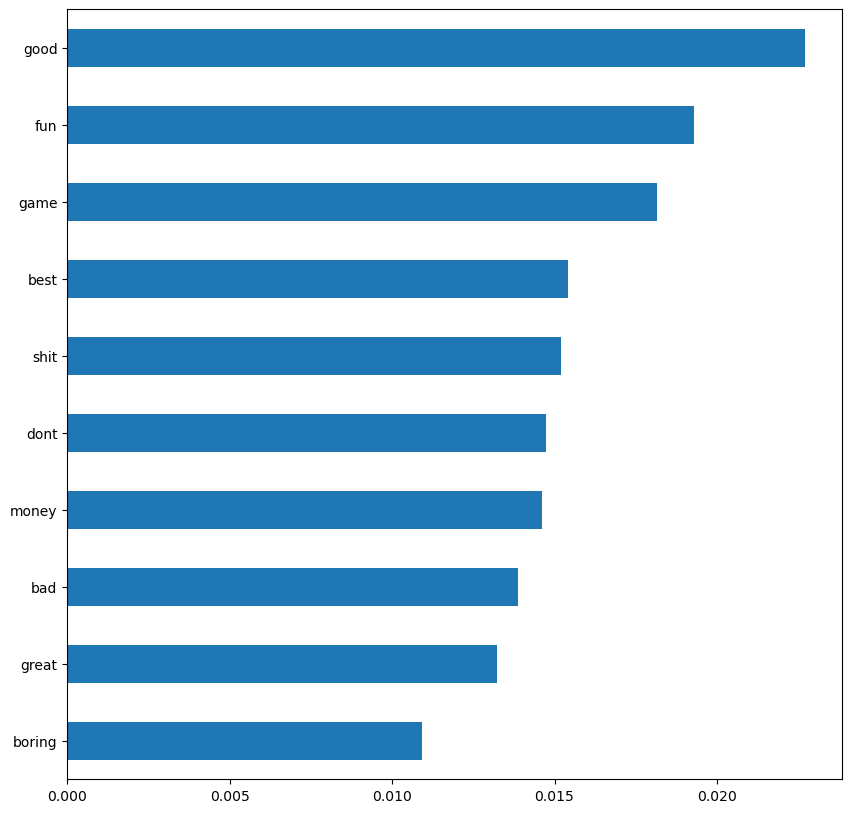

In [71]:
feat_imp = feature_scores.nlargest(10).sort_values(ascending=True)
feat_imp.plot(kind = 'barh', figsize = (10,10))
plt.savefig('feat_imp.png', bbox_inches="tight")

In [72]:
from sklearn.metrics import confusion_matrix

y_pred = (y_pred_proba > optimal_thresh)
conf_mat = confusion_matrix(y_test, y_pred.astype(int), labels = [1,0])
conf_mat

array([[244,  56],
       [ 79, 221]], dtype=int64)

In [73]:
print(X_test.shape)
y_pred_df = y_pred.astype(int)
X_variables = pd.DataFrame(X_test)
X_variables['predictions'] = y_pred_df

(600,)


In [74]:
negative_reviews = X_variables[X_variables['predictions'] == 1 ]
negative_reviews.head(10)


,reviews_fin,predictions
112,good,1
121,one buggy game game,1
152,worst game ever purchased,1
197,payday player robbery simulator game friend ga...,1
219,epic ruined game longer play online,1
229,lagging rtxtigb ram processor k stutter lag ev...,1
230,stinky poo poo fortnite car ball,1
253,fun gameplay corrupted save end playthrough fr...,1
288,loading simulator,1
317,fun game thing,1


In [75]:
negative_reviews.count()

reviews_fin    323
predictions    323
dtype: int64

In [76]:
X_variables.iloc[ind]

reviews_fin    fun gameplay corrupted save end playthrough fr...
predictions                                                    1
Name: 253, dtype: object

## Unused Code For Now

In [77]:
import tensorflow.keras

In [78]:
nn_train_data = pd.concat([X_train, y_train], axis = 1)
nn_train_data.value_counts('recommended')

recommended
False    1200
True     1200
Name: count, dtype: int64

In [79]:
nn_balance = nn_train_data[nn_train_data['recommended']==0].sample(4198, random_state = 48)
nn_balance.value_counts('recommended')
nn_train = pd.concat([nn_balance, nn_train_data[nn_train_data['recommended']==1]])
nn_train.value_counts('recommended')
nn_xtrain = nn_train['reviews_fin']
nn_ytrain = nn_train['recommended']

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
vectorizer = TfidfVectorizer()
X_train_arr = vectorizer.fit_transform(nn_xtrain).toarray()

In [ ]:
X_test_arr = vectorizer.transform(X_test).toarray()

In [ ]:
print(X_train_arr.shape, X_test_arr.shape)

In [ ]:
n_words = X_train_arr.shape[1]
n_words

In [ ]:
nn_ytrain.value_counts()
y_test.value_counts()

In [ ]:
#nn model
model = Sequential()
model.add(Dense(200, input_shape = (n_words,), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(100, activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(1, activation ='sigmoid'))

tensorBoardCallback = TensorBoard(log_dir = './logs', write_graph = True)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
start_time = datetime.datetime.now()

history = model.fit(X_train_arr, nn_ytrain, epochs = 10, callbacks=[tensorBoardCallback], verbose = 2,
                   validation_data = (X_test_arr, y_test))



In [ ]:
loss, acc = model.evaluate(X_test_arr, y_test, verbose = 0)
print('Test Accuracy: %f' % (acc*100))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(["Train", "test"], loc = 'upper right')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Train", "test"], loc = 'upper right')
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

In [ ]:
precision.shape, recall.shape, thresholds.shape

In [ ]:
precision = np.delete(precision, -1)
recall = np.delete(recall, -1)

precision.shape, recall.shape, thresholds.shape

In [ ]:
#locate recall from selected precision

precision_score = optimal_prec
find_recall = interpolate.interp1d(precision, recall)
find_thresh = interpolate.interp1d(precision, thresholds)
thresh_value = find_thresh(precision_score)
recall_score = find_recall(precision_score)
recall_score, thresh_value

In [ ]:
plt.plot(recall, precision, label = 'auc=%.3f' % auc, marker = '.')
plt.plot(recall_score, precision_score, marker = 'o', color = 'black', label = 'Best')
plt.title(label = 'Precision Recall Curve')
plt.show()


In [ ]:
tpr_opt = find_tpr(thresh_value)
fpr_opt = find_fpr(thresh_value)
print(tpr_opt, fpr_opt, thresh_value)

In [ ]:
#locating optimal point
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

find_tpr = interpolate.interp1d(thresholds, tpr) #plug in thresholds for tpr
find_fpr = interpolate.interp1d(thresholds, fpr) #plug in thresh for fpr
thresh_look = interpolate.interp1d(tpr, thresholds) #plug in tpr for thresholds


In [ ]:
ttt = thresh_look(0.6) #threshold value for value of tpr
ttt

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)
plt.plot([0,1],[0,1], linestyle ='--')
plt.plot(fpr, tpr, label = 'auc=%.3f' % auc, marker = '.')
plt.plot(fpr_opt, tpr_opt, marker = 'o', color = 'black')
plt.title(label = 'ROC Curve Random Forest Classifier')
plt.show()

In [ ]:
y_pred_opt = (y_pred_proba > ttt)
conf_mat_opt = confusion_matrix(y_test, y_pred_opt, labels = [0,1])
conf_mat_opt

In [ ]:
#find best true negative (tn) results
tn = 7000
best_thresh = 0
for t in high_thresh:
    y_pred_opt = (y_pred_proba > t)
    conf_mat_opt = confusion_matrix(y_test, y_pred_opt, labels = [0,1])
    if conf_mat_opt[1][0] > tn:
        best_thresh = t
        tn = conf_mat_opt[1][0]
        conf_mat_best = conf_mat_opt

best_thresh, tn, conf_mat_best

In [ ]:
high_thresh = thresholds[thresholds > 0.5]
high_thresh

In [ ]:
from sklearn.metrics import accuracy_score

#accuracy prior to choosing threshold
accuracy = accuracy_score(y_test, y_pred_proba.astype('int'))
print(accuracy)

In [ ]:
y_pred = y_pred_proba
y_pred = (y_pred >= opt_thresh).astype('int')

accuracy_thresh = accuracy_score(y_test, y_pred)
print(accuracy_thresh)

In [ ]:
plt.plot(recall, precision, label = 'auc=%.3f' % auc, marker = '.')
plt.plot(0.9, prec_point, marker = 'o', color = 'black', label = 'Best')
plt.title(label = 'Precision Recall Curve')
plt.show()
